In [1]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the 6GB model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive or save_models_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False
      save_models_to_google_drive = False

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/models/ldm/text2img-large"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Diffusion" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")


Mounted at /content/gdrive
Model will be stored at /content/gdrive/MyDrive/AI/models
Outputs will be saved to /content/gdrive/MyDrive/AI/Latent_Diffusion


In [2]:
# Clone repositories only if they don't exist
import os

if not os.path.exists('latent-diffusion'):
    !git clone https://github.com/crowsonkb/latent-diffusion.git

if not os.path.exists('taming-transformers'):
    !git clone https://github.com/CompVis/taming-transformers

# Replace `torch._six` import issue in taming-transformers
!sed -i 's/from torch._six import string_classes/from collections.abc import Iterable/' ./taming-transformers/taming/data/utils.py

# Install dependencies
!pip install torch==1.13.1 torchvision==0.14.1
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras

# Update Python path
import sys
sys.path.append(".")
sys.path.append("./taming-transformers")
sys.path.append("./latent-diffusion")

# Test import
from taming.models import vqgan
print("taming-transformers imported successfully!")


Cloning into 'latent-diffusion'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 270 (delta 73), reused 67 (delta 67), pack-reused 144 (from 1)
Receiving objects: 100% (270/270), 28.39 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340 (from 1)
Receiving objects: 100% (1342/1342), 409.77 MiB | 23.88 MiB/s, done.
Resolving deltas: 100% (282/282), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0

In [3]:
# @title fetch
%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

/content/latent-diffusion
Using saved model from Google Drive


In [4]:
# @title ldm utility loader
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

In [5]:
# @title mass import
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None])
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip
import tensorflow as tf

In [10]:
!sed -i 's/from pytorch_lightning.utilities.distributed import rank_zero_only/from pytorch_lightning.utilities.rank_zero import rank_zero_only/' /content/latent-diffusion/ldm/models/diffusion/ddpm.py

In [11]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model



config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml")
model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
from open_clip import create_model_and_transforms

# Initialize the CLIP model and preprocess function
clip_model_name = "ViT-B-32"
pretrained_dataset = "laion400m_e32"  # Specify the dataset used for pretraining

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model, preprocess function, and tokenizer
clip_model, preprocess, tokenizer = create_model_and_transforms(
    clip_model_name,
    pretrained=pretrained_dataset,
    device=device,
)

clip_model.eval()


# Define the run function
def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt
    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))

    all_samples = list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image_vector = Image.fromarray(x_sample.astype(np.uint8))
                        image = preprocess(image_vector).unsqueeze(0).to(dtype=torch.float16, device=device)
                        with torch.no_grad():
                            image_features = clip_model.encode_image(image)
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        query = image_features.cpu().detach().numpy().astype("float32")
                        base_count += 1
                    all_samples.append(x_samples_ddim)

    # Save the final grid image
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))

    # Example usage
    generated_image_path = os.path.join(outpath, f'{prompt.replace(" ", "-")}.png')  # Replace with actual path
    original, adjusted = adjust_image_properties(generated_image_path)

    # Display the images
    display_images(original, adjusted)



Loading model from /content/gdrive/MyDrive/AI/models/latent_diffusion_txt2img_f8_large.ckpt


<ipython-input-11-47092954ce5b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt, map_location="cuda:0")


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 872.30 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [6]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

def adjust_image_properties(generated_image_path,
                            brightness_factor=1.2,
                            contrast_factor=1.5,
                            saturation_factor=1.3):
    """
    Adjust the brightness, contrast, and saturation of an image.

    Parameters:
        generated_image_path (str): Path to the generated image.
        brightness_factor (float): Factor to adjust brightness. Default is 1.2.
        contrast_factor (float): Factor to adjust contrast. Default is 1.5.
        saturation_factor (float): Factor to adjust saturation. Default is 1.3.

    Returns:
        original_image (PIL.Image.Image): The original image.
        adjusted_image (PIL.Image.Image): The adjusted image.
    """
    # Load the image
    original_image = Image.open(generated_image_path)

    # Adjust brightness
    enhancer = ImageEnhance.Brightness(original_image)
    brightened_image = enhancer.enhance(brightness_factor)

    # Adjust contrast
    enhancer = ImageEnhance.Contrast(brightened_image)
    contrasted_image = enhancer.enhance(contrast_factor)

    # Adjust saturation
    enhancer = ImageEnhance.Color(contrasted_image)
    adjusted_image = enhancer.enhance(saturation_factor)

    return original_image, adjusted_image

def display_images(original_image, adjusted_image):
    """
    Display the original and adjusted images side by side.

    Parameters:
        original_image (PIL.Image.Image): The original image.
        adjusted_image (PIL.Image.Image): The adjusted image.
    """
    # Display the original and adjusted images
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Before")
    plt.axis("off")

    # Adjusted Image
    plt.subplot(1, 2, 2)
    plt.imshow(adjusted_image)
    plt.title("After (Adjusted)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


<ipython-input-11-47092954ce5b>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for PLMS sampling is (3, 4, 32, 32)
Running PLMS Sampling with 50 timesteps


PLMS Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

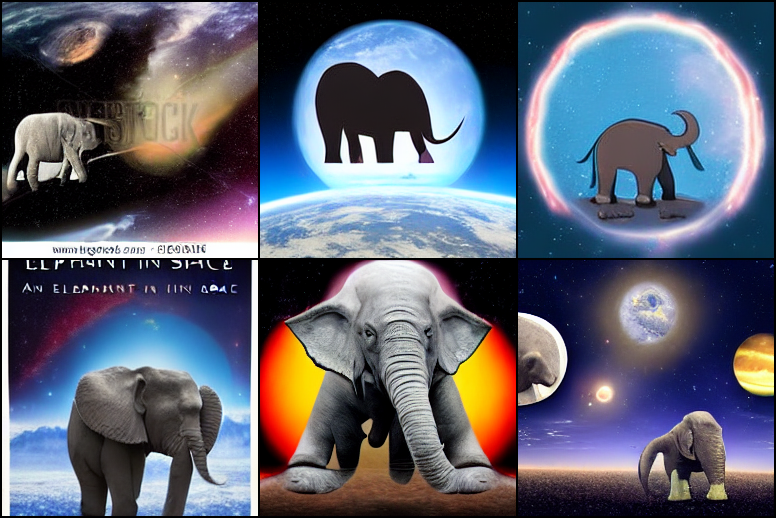

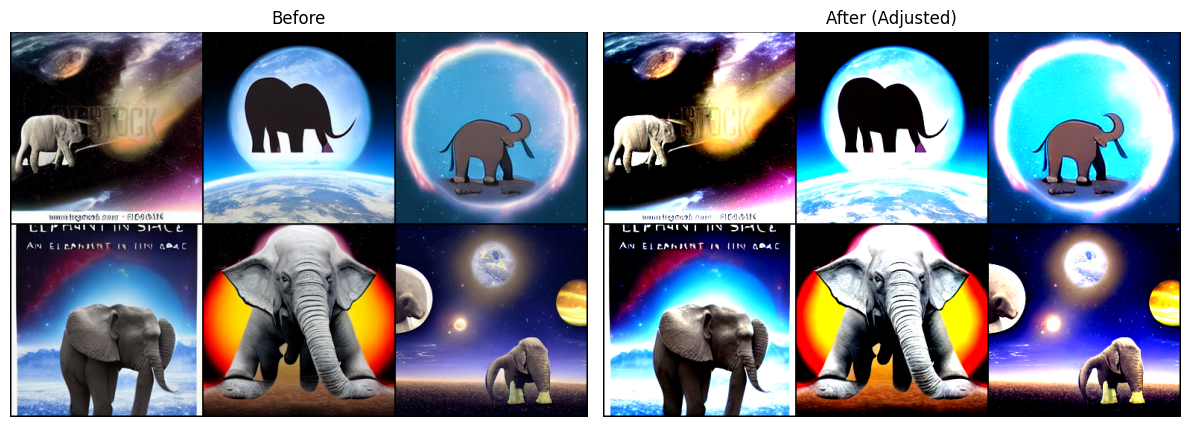

In [15]:
#@title generate images
import argparse
Prompt = "An elephant in space" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0.0 #@param{type:"number"}
Iterations = 2 #@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}

args = argparse.Namespace(
    prompt = Prompt,
    outdir=f'{outputs_path}',
    ddim_steps = Steps,
    ddim_eta = ETA,
    n_iter = Iterations,
    W=Width,
    H=Height,
    n_samples=Samples_in_parallel,
    scale=Diversity_scale,
    plms=PLMS_sampling,
    nsfw_threshold=0.5
)
run(args)